In [1]:
import torch.nn as nn
import torch
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader
from data_load import load_soil_data
from data_processing import process_spectra
from data_processing import preprocess_with_downsampling
from resnet1d_multitask import ResNet1D_MultiTask,get_model

2.5.1+cu118
True
CUDA is available. Using NVIDIA GeForce RTX 4060 Ti


In [3]:
# 定义目标列
target_columns = ['pH.in.CaCl2', 'pH.in.H2O', 'OC', 'CaCO3', 'N', 'P', 'K', 'CEC']

# 加载数据
X_train, X_test, y_train, y_test, wavelengths = load_soil_data('../LUCAS.2009_abs.csv', target_columns)

# 确保数据形状为 (n_samples, n_wavelengths)
X_train, X_test = X_train.squeeze(), X_test.squeeze()

# 预处理数据
methods = ['Abs-SG0', 'Abs-SG0-SNV', 'Abs-SG1', 
              'Abs-SG1-SNV', 'Abs-SG2', 'Abs-SG2-SNV']
bin_sizes = [5,10,15,20]  # 不同的降采样窗口大小
X_train= process_spectra(X_train,methods[3])
X_test = process_spectra(X_test,methods[3])

X_train,X_train_nwavelengths=preprocess_with_downsampling(X_train,wavelengths,bin_sizes[2])
X_test,X_test_nwavelengths=preprocess_with_downsampling(X_test,wavelengths,bin_sizes[2])
# 将数据形状调整为 (n_samples, 1, n_wavelengths)
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

# 检查数据形状
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)
assert X_train.shape[0] == y_train.shape[0], "Mismatch in number of samples between X_train and y_train"
assert X_test.shape[0] == y_test.shape[0], "Mismatch in number of samples between X_test and y_test"

# 创建数据加载器
train_dataset = torch.utils.data.TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
test_dataset = torch.utils.data.TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32))

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

X_train shape: (15228, 1, 130)
y_train shape: (15228, 8)
X_test shape: (3807, 1, 130)
y_test shape: (3807, 8)


In [4]:
# 模型参数设置
model = get_model('C')

# 损失函数
criterion = nn.SmoothL1Loss()

# 优化器
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.81)

In [5]:
from sklearn.metrics import root_mean_squared_error, r2_score
import numpy as np
# 训练参数
num_epochs = 100
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# 初始化指标列表
train_losses = []
train_rmse = []
train_r2 = []

# 训练循环
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    all_preds = []
    all_targets = []
     
    for batch_x, batch_y in train_loader:
        # 移动数据到设备
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        # 前向传播
        outputs = model(batch_x)
        # 计算损失
        loss = criterion(outputs, batch_y)
        # 反向传播和优化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        # 收集预测和真实值
        all_preds.append(outputs.cpu().detach().numpy())
        all_targets.append(batch_y.cpu().detach().numpy())
        
        train_losses.append(total_loss / len(train_loader))
        
    # 更新学习率
    scheduler.step()  # 在每个epoch结束后调整学习率
    # 计算RMSE和R²
    all_preds = np.concatenate(all_preds, axis=0)
    all_targets = np.concatenate(all_targets, axis=0)
    epoch_rmse = root_mean_squared_error(all_targets, all_preds)
    epoch_r2 = r2_score(all_targets, all_preds)
    train_rmse.append(epoch_rmse)
    train_r2.append(epoch_r2)
    
    # 打印每轮训练的平均损失和指标
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_losses[-1]:.4f}, RMSE: {epoch_rmse:.4f}, R2: {epoch_r2:.4f}')
    if epoch % 20 == 0: torch.save(model.state_dict(), f'models/now.pth')

Epoch [1/100], Loss: 33.9448, RMSE: 69.7849, R2: -0.4280
Epoch [2/100], Loss: 28.8905, RMSE: 63.9639, R2: -0.0229
Epoch [3/100], Loss: 28.3974, RMSE: 63.0714, R2: 0.0427
Epoch [4/100], Loss: 28.0716, RMSE: 62.5553, R2: 0.0710
Epoch [5/100], Loss: 27.4575, RMSE: 61.1024, R2: 0.1529
Epoch [6/100], Loss: 26.3365, RMSE: 57.5674, R2: 0.2648
Epoch [7/100], Loss: 25.7161, RMSE: 55.9864, R2: 0.3006
Epoch [8/100], Loss: 25.4030, RMSE: 55.4972, R2: 0.3164
Epoch [9/100], Loss: 24.9097, RMSE: 54.3405, R2: 0.3484
Epoch [10/100], Loss: 23.4980, RMSE: 50.7502, R2: 0.3968
Epoch [11/100], Loss: 22.9915, RMSE: 49.8383, R2: 0.4053
Epoch [12/100], Loss: 22.6047, RMSE: 48.6838, R2: 0.4341
Epoch [13/100], Loss: 22.0536, RMSE: 47.7625, R2: 0.4444
Epoch [14/100], Loss: 21.8895, RMSE: 47.2756, R2: 0.4584
Epoch [15/100], Loss: 21.6260, RMSE: 46.7802, R2: 0.4626
Epoch [16/100], Loss: 21.3705, RMSE: 46.4082, R2: 0.4749
Epoch [17/100], Loss: 21.2690, RMSE: 46.0298, R2: 0.4839
Epoch [18/100], Loss: 21.0098, RMSE: 4

In [8]:
from sklearn.metrics import root_mean_squared_error, r2_score

# 模型评估
model.eval()
total_test_loss = 0
test_preds = []
test_targets = []

# 将列名和索引建立映射
target_columns = ['pH.in.CaCl2', 'pH.in.H2O', 'OC', 'CaCO3', 'N', 'P', 'K', 'CEC']
column_mapping = {i: col for i, col in enumerate(target_columns)}

with torch.no_grad():
    for batch_x, batch_y in test_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        test_outputs = model(batch_x)
        test_loss = criterion(test_outputs, batch_y)
        total_test_loss += test_loss.item()

        # 收集预测值和真实值
        test_preds.append(test_outputs.cpu().numpy())
        test_targets.append(batch_y.cpu().numpy())

    # 计算平均测试损失
    avg_test_loss = total_test_loss / len(test_loader)
    print(f'Average Test Loss: {avg_test_loss:.4f}')

    # 将预测值和真实值拼接在一起
    test_preds = np.concatenate(test_preds, axis=0)
    test_targets = np.concatenate(test_targets, axis=0)

    # 计算每个指标的 RMSE 和 R²
    for i in range(test_targets.shape[1]):
        target_i = test_targets[:, i]
        pred_i = test_preds[:, i]

        # 计算 RMSE 和 R²
        rmse_i = np.sqrt(root_mean_squared_error(target_i, pred_i))
        r2_i = r2_score(target_i, pred_i)

        # 打印当前指标的结果
        print(f'Indicator {i + 1} ({column_mapping[i]}) - RMSE: {rmse_i:.4f}, R²: {r2_i:.4f}')
# 可选：保存模型
#torch.save(model.state_dict(), 'models/resnet1d50_new_model.pth')

Average Test Loss: 16.3081
Indicator 1 (pH.in.CaCl2) - RMSE: 0.8083, R²: 0.7902
Indicator 2 (pH.in.H2O) - RMSE: 0.7884, R²: 0.7881
Indicator 3 (OC) - RMSE: 5.2944, R²: 0.8994
Indicator 4 (CaCO3) - RMSE: 6.1148, R²: 0.9063
Indicator 5 (N) - RMSE: 1.2336, R²: 0.8161
Indicator 6 (P) - RMSE: 5.8376, R²: 0.1469
Indicator 7 (K) - RMSE: 12.5448, R²: 0.3947
Indicator 8 (CEC) - RMSE: 2.8166, R²: 0.6321


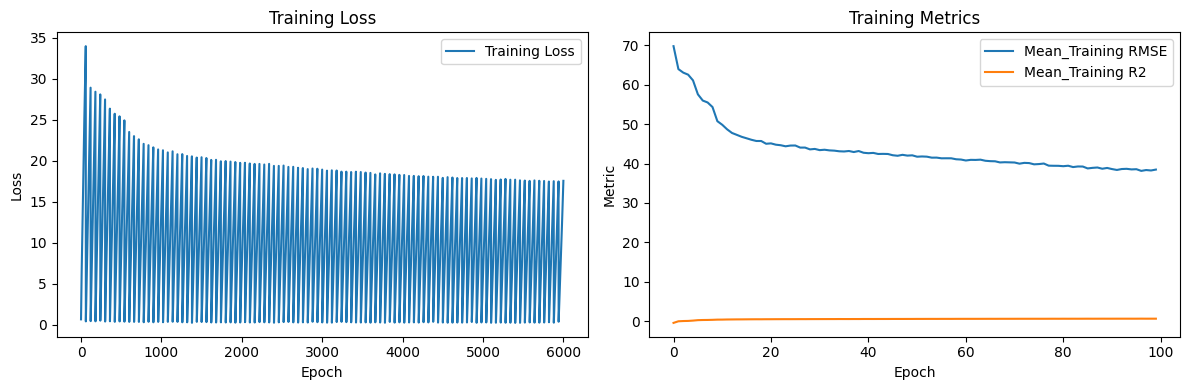

In [9]:




plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
train_losses = np.array(train_losses)
train_losses = train_losses[train_losses != 0]
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_rmse, label='Mean_Training RMSE')
plt.plot(train_r2, label='Mean_Training R2')
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.title('Training Metrics')
plt.legend()

plt.tight_layout()
plt.show()